In [20]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import folium as fl
import wordcloud as wc
from wordcloud import STOPWORDS,WordCloud
import collections
import nltk
from nltk import word_tokenize
nltk.download('punkt')
# nltk.download(u'stopwords')
# from nltk.corpus import stopwords
# import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer,PorterStemmer
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
months = ['\\april','\\febrouary','\march']
months2 = ['febrouary','march','april']
files = ['\listings.csv','\listings0.csv']
# inputPath= r"C:\Users\myrto\Desktop\data"
inputPath= r"C:\Users\nikol\Desktop\dataMining_p1\data\data"
columnlist = ['id','zipcode','transit','bedrooms','beds','review_scores_rating','number_of_reviews','neighbourhood','name','latitude','longitude','last_review','instant_bookable','host_since','host_response_rate','host_identity_verified','host_has_profile_pic','first_review','description','city','cancellation_policy','bed_type','bathrooms','accommodates','amenities','room_type','property_type','price','availability_365','minimum_nights','host_id']

framelist = []
monthlist = []
i=0
for month in months:
    for file in files:
        tempfile = pd.read_csv(inputPath+month+file,index_col=False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df = pd.DataFrame(data = train, columns=columnlist)
    df.drop_duplicates(subset='id',ignore_index=True,inplace=True)
    df.insert(loc=len(df.columns),column='month_id',value=months2[i])
    monthlist.append(df)
    i=i+1

df = pd.concat(monthlist)
df['price'] = df['price'].apply(lambda x: x.translate(str.maketrans({',':'','$':''})))
df['price'] = pd.to_numeric(df['price'])

for x in df.select_dtypes('number').columns:
    df[x].fillna(df[x].mean(),inplace=True)
df.fillna(method='backfill',inplace=True)
df.dropna(inplace=True)
df.to_csv("train.csv")

df.isna().sum()

id                        0
zipcode                   0
transit                   0
bedrooms                  0
beds                      0
review_scores_rating      0
number_of_reviews         0
neighbourhood             0
name                      0
latitude                  0
longitude                 0
last_review               0
instant_bookable          0
host_since                0
host_response_rate        0
host_identity_verified    0
host_has_profile_pic      0
first_review              0
description               0
city                      0
cancellation_policy       0
bed_type                  0
bathrooms                 0
accommodates              0
amenities                 0
room_type                 0
property_type             0
price                     0
availability_365          0
minimum_nights            0
host_id                   0
month_id                  0
dtype: int64

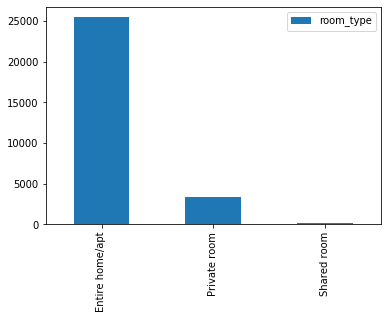

In [131]:
# 1
dt = df['room_type'].value_counts()
tempdf = DataFrame(data=dt)
tempdf.plot.bar()

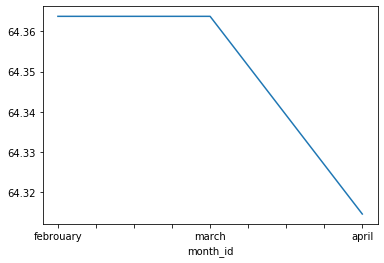

In [129]:
# 2
groupbymonth = df.groupby(by='month_id',sort=False)['price'].mean().plot(x='per_month',y='price')

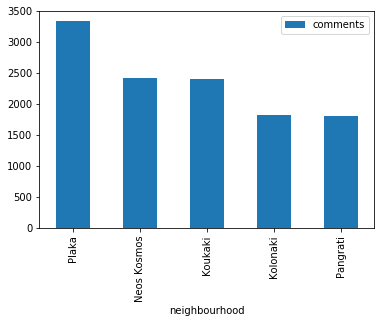

In [139]:
# 3

temp = df[['id','neighbourhood']]
# reviews = r'C:\Users\myrto\Desktop\data\april\reviews.csv'
# reviews0 = r'C:\Users\myrto\Desktop\data\april\reviews0.csv'
reviews = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews.csv'
reviews0 = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews0.csv'
reviews = pd.read_csv(reviews,usecols=['id','comments'])
reviews0 = pd.read_csv(reviews0)
reviews = pd.DataFrame(data=reviews)
reviews0 = pd.DataFrame(data=reviews0)
reviews = reviews.combine_first(reviews0)
reviews.dropna(inplace=True)
temp = temp.combine_first(reviews)
temp = temp[['neighbourhood','comments']].groupby('neighbourhood',as_index=False).count()
temp = temp.sort_values(['comments'],ascending=False)
temp.head(5).plot.bar(x='neighbourhood')


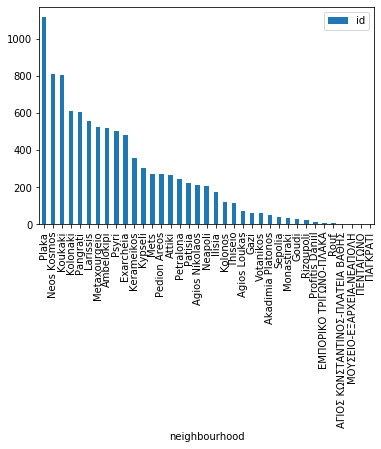

In [142]:
#4
df.groupby(by='neighbourhood',as_index=False).agg({'id':'nunique'}).sort_values(['id'],ascending=False,ignore_index=True).plot.bar(x='neighbourhood')

In [158]:
#5
temp = df.groupby(['neighbourhood','month_id']).size()
# d = temp.tolist()
# x = df['neighbourhood'].tolist()
# print(x)
temp = DataFrame(data=temp)
temp
# ax = plt.subplot(111)
# ax.bar(d, y, width=0.2, color='b', align='center')
# ax.bar(x, z, width=0.2, color='g', align='center')
# ax.bar(x+0.2, k, width=0.2, color='r', align='center')

# plt.show()

0
neighbourhood            month_id      
Agios Loukas             april       71
                         febrouary   71
                         march       71
Agios Nikolaos           april      208
                         febrouary  209
...                                 ...
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ   febrouary    6
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ april        1
                         febrouary    1
ΠΑΓΚΡΑΤΙ                 febrouary    1
ΠΕΝΤΑΓΩΝΟ                febrouary    2

[103 rows x 1 columns]

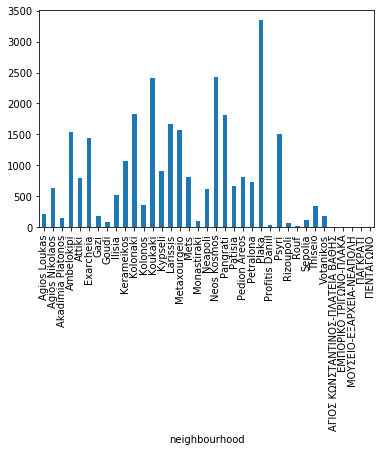

In [10]:
#6
graph = df.groupby(by='neighbourhood').size()
graph.plot.bar(y='Count',x='Neighbourhoods')

In [8]:
#7
temp = df[['room_type','neighbourhood','host_id']]
temp.dropna(inplace=True)
temp.drop_duplicates(subset='host_id',inplace=True)
temp = temp.groupby(['neighbourhood','room_type']).size().sort_values(ascending=False)
temp


neighbourhood    room_type      
Plaka            Entire home/apt    285
Koukaki          Entire home/apt    283
Neos Kosmos      Entire home/apt    249
Kolonaki         Entire home/apt    198
Ambelokipi       Entire home/apt    187
                                   ... 
Profitis Daniil  Shared room          1
Kolonos          Shared room          1
Patisia          Private room         1
Monastiraki      Private room         1
ΠΕΝΤΑΓΩΝΟ        Entire home/apt      1
Length: 63, dtype: int64

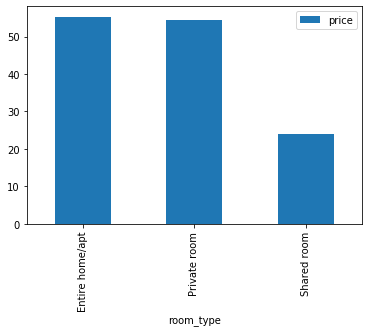

In [159]:
# 8
tempdf = df[['room_type','host_id','price']]
tempdf.drop_duplicates(subset='host_id',inplace=True)
tempdf.groupby(by=['room_type'],as_index=False).agg({'price':'mean'}).sort_values(['price'],ascending=False,ignore_index=True).plot.bar(x='room_type')

In [21]:
# 9
latitude = []
longitude = []
tempdf = df[['latitude','longitude','host_id','price','bed_type','room_type']]
tempdf.drop_duplicates(subset='host_id',inplace=True)
latitude = tempdf['latitude'].tolist()
longitude = tempdf['longitude'].tolist()
price = tempdf['price'].tolist()
btype = tempdf['bed_type'].tolist()
rtype = tempdf['room_type'].tolist()

tooltip = 'Click me!'

m = fl.Map(location=[latitude[0],longitude[0]], zoom_start=12,tiles='Stamen Terrain')

for i, j in zip(range(1,100),range(1,100)):
    fl.Marker(location=[latitude[i], longitude[j]], icon=fl.Icon(color='red', icon='info-sign'),tooltip=tooltip,popup=('$'+str(price[i])+'\n'+str(rtype[i])+'\n'+str(btype[i]))).add_to(m)
m



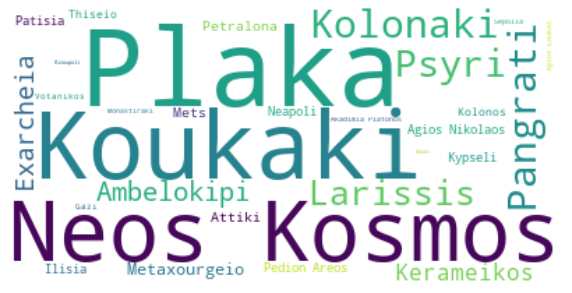

In [14]:
# 10 - neighbourhood

text = df['neighbourhood']
text = text.tolist()
tuples = collections.Counter(text)

words = WordCloud(background_color='white').generate_from_frequencies(frequencies=dict(tuples))

plt.figure(figsize=(10,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()



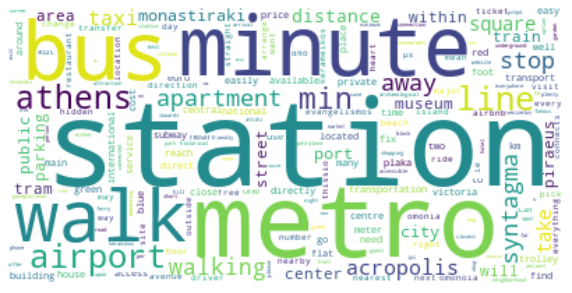

In [23]:
# 10 - transit

stopwords = set(STOPWORDS)
textWords = []
for x in df['transit']:
    for y in word_tokenize(x) :
        y = y.lower()
        y = WordNetLemmatizer().lemmatize(y)
        if (y not in stopwords) and y.isalpha():
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(10,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()


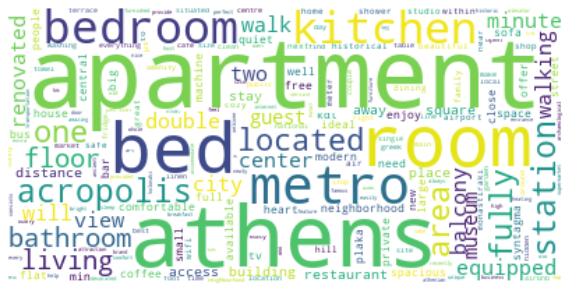

In [16]:
# 10 - description

stopwords = set(STOPWORDS)
textWords = []
for x in df['description']:
    for y in word_tokenize(x) :
        y = y.lower()
        if (y not in stopwords) and (y not in stopwords) and y.isalpha():
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(10,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()


In [164]:
# 10 - last_review

temp = df['last_review']
dates = temp.tolist()
temp = df['id']
ids = temp.tolist()

rev = DataFrame(data=reviews[['date','comments','listing_id']])
temp  = rev.loc[(rev['date'].isin(dates)) & (rev['listing_id'].isin(ids))]

stopwords = set(STOPWORDS)
textWords = []
for x in temp['comments']:
    for y in word_tokenize(x) :
        y = y.lower()
        if (y not in stopwords) and y.isalpha():
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(10,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()


0       2019-04-08
1       2017-11-23
2       2019-03-03
3       2019-04-04
4       2019-04-04
           ...    
9578    2019-04-12
9579    2019-04-12
9580    2019-04-12
9581    2019-04-12
9582    2019-04-12
Name: last_review, Length: 28905, dtype: object

In [84]:
# 12-a
def findRating(a,b,c):
    return (0.2*a+0.5*b+0.3*c)/10
tempdf = df.drop_duplicates('host_id')
neighbourhoodsCost = tempdf.groupby('neighbourhood').agg({'price':'mean','availability_365':'mean','host_id':'count'}).reset_index()
neighbourhoodsCost = neighbourhoodsCost.rename(columns = {'price':'Average price','availability_365':'Average availability','host_id':'#hotels'})
neighbourhoodsCost['Ranking'] = neighbourhoodsCost.apply(lambda row : findRating(row['Average price'],row['Average availability'],row['#hotels']),axis=1)
temp = neighbourhoodsCost.sort_values('Ranking',ascending=False,ignore_index=True)
temp

,neighbourhood,Average price,Average availability,#hotels,Ranking
0,Plaka,86.686316,214.945263,475,26.730989
1,Neos Kosmos,67.140725,210.584222,469,25.942026
2,Koukaki,55.429530,210.418345,447,25.039508
3,Kolonaki,73.526582,228.111392,395,24.726101
4,Ambelokipi,48.672727,219.238961,385,23.485403
5,Pangrati,46.153646,206.429688,384,22.764557
6,Exarcheia,42.993651,216.203175,315,21.120032
7,Larissis,42.016892,222.324324,296,20.836554
8,ΠΑΓΚΡΑΤΙ,80.000000,363.000000,1,19.780000
9,Metaxourgeio,51.804781,213.725100,251,19.252351


In [88]:
# 12-b

neighbourhoodsCost = df.groupby('neighbourhood').agg({'review_scores_rating':'mean','id':'count'}).sort_values('review_scores_rating',ascending=False)
neighbourhoodsCost
# neighbourhoodsCost['Ranking'] = neighbourhoodsCost.apply(lambda row : findRating(row['Average price'],row['Average availability'],row['#hotels']),axis=1)


,review_scores_rating,id
neighbourhood,,
ΠΕΝΤΑΓΩΝΟ,97.718337,2
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,97.718337,2
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ,97.718337,2
Sepolia,97.305396,110
Kolonos,96.733587,357
Gazi,96.635263,185
Akadimia Platonos,96.394683,141
Thiseio,96.306221,336
Koukaki,96.141739,2404
